# Visualizing the results from the trained *MobileNetV3* model

### Importing required libraries

In [2]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load the trained model from the saved file
from model import MobileNetV3Segmentation

import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from loader import load_data # imports your DataLoader for the validation set
from tqdm import tqdm

from ellipse_fitting import fit_ellipse_from_mask, create_ellipse_mask

from metrics import dice_score, calculate_metrics, count_trainable_params, model_size_in_mb

### Loading path to sample image for getting it's predicted mask

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load a single image and its corresponding mask
image_path = '../data/val_resized/slices/0d0a3298-a9c6-43c3-a9e3-df3a9c0afa06_slice_45.png'  # Replace with your image path
mask_path = '../data/val_resized/masks/0d0a3298-a9c6-43c3-a9e3-df3a9c0afa06_slice_45_mask.png'      # Replace with your mask path

# Load and transform the image
image = Image.open(image_path).convert("RGB")
image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)  # Add batch dimension and send to device

# Load and transform the mask
original_mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale
original_mask_tensor = transforms.ToTensor()(original_mask).unsqueeze(0).to(device)  # Add batch dimension

### Loading the model for predictions

In [5]:
model = MobileNetV3Segmentation().to(device)
model.load_state_dict(torch.load('./model/mobilenetv3_model.pth')) # give path to the model.
model.eval()

/tmp/ipykernel_14715/2830775338.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/ryzen/Desktop/MobileNetV3/src/model/mobilenetv3_m

MobileNetV3Segmentation(
  (base_model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv

### Making predictions

In [6]:
# Predict the mask
with torch.no_grad():
    output = model(image_tensor)  # Forward pass with the input image
    output = torch.sigmoid(output)  # Apply sigmoid to get values between 0 and 1
    predicted_mask = (output > 0.5).float()  # Binarize the output (1 for values > 0.5, 0 otherwise)
    predicted_mask = predicted_mask.squeeze(0).cpu().numpy()  # Remove batch dimension and convert to NumPy

### Visualizing the prediction

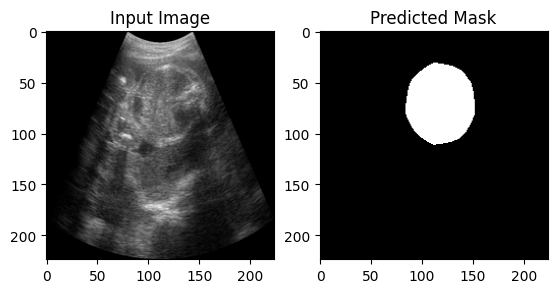

In [8]:
# Visualize the image and predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(original_mask, cmap='gray')
plt.title('Input Image')

# Check if the predicted_mask is a tensor
if isinstance(predicted_mask, torch.Tensor):
    predicted_mask = predicted_mask.squeeze().cpu().numpy()  # Convert tensor to numpy
else:
    predicted_mask = predicted_mask.squeeze()  # If it's already a numpy array

# Plot the predicted mask
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')
plt.show()

### Calling the ellipse function and fitting it on the predicted mask

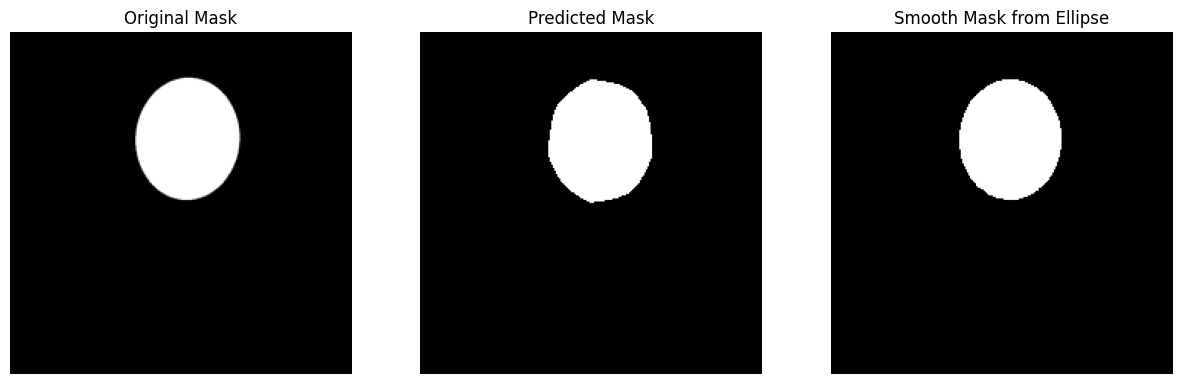

In [9]:


# Ensure predicted_mask is 2D
predicted_mask_2d = np.squeeze(predicted_mask)  # Remove any extra dimensions

# Find and fit the ellipse on the predicted mask
ellipse = fit_ellipse_from_mask(predicted_mask_2d)

# Create a smooth mask based on the fitted ellipse
if ellipse is not None:
    ellipse_mask = create_ellipse_mask(predicted_mask_2d.shape, ellipse)
else:
    ellipse_mask = np.zeros(predicted_mask_2d.shape, dtype=np.uint8)  # If no ellipse, return an empty mask

# Visualize the original mask, predicted mask, and the ellipse mask
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_mask, cmap='gray')
plt.title('Original Mask')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask_2d, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(ellipse_mask, cmap='gray')
plt.title('Smooth Mask from Ellipse')
plt.axis('off')

plt.show()


### Calculating the performance metrics for the model

In [12]:
# Define paths for your datasets
train_data_dir = "../data/train_resized/slices"
train_mask_dir = "../data/train_resized/masks"
val_data_dir = "../data/val_resized/slices"
val_mask_dir = "../data/val_resized/masks"
train_loader, val_loader = load_data(train_data_dir, train_mask_dir, val_data_dir, val_mask_dir)
# Variables to store total metrics
total_dice_score = 0.0
num_batches = 0
all_preds = []
all_masks = []

# Inference loop to calculate metrics on the validation set
with torch.no_grad():  # Disable gradient computation for evaluation
    for images, masks in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)
        masks = masks.to(device).float()  # Assuming masks are binary (0, 1)
        
        # Get predictions from the model
        preds = model(images)
        preds = torch.sigmoid(preds)  # Apply sigmoid to get probabilities
        
        # Store predictions and masks for metric calculations
        all_preds.append(preds.cpu().numpy())
        all_masks.append(masks.cpu().numpy())
        
        # Convert predictions to binary masks
        preds_binary = (preds > 0.5).float()  # Binarize predictions

        # Calculate DICE score for the current batch
        batch_dice_score = dice_score(masks, preds_binary)  # Call DICE score function
        total_dice_score += batch_dice_score.item()  # Accumulate DICE score
        num_batches += 1  # Increment number of batches

# Concatenate all predictions and masks from batches
all_preds = np.concatenate(all_preds)
all_masks = np.concatenate(all_masks)

# Calculate the average DICE score across all batches
average_dice_score = total_dice_score / num_batches
print(f"Average DICE Score on the validation set: {average_dice_score:.4f}")

# Flatten masks and predictions for metric calculations
all_preds_flat = all_preds.flatten()
all_masks_flat = all_masks.flatten()

# Calculate other metrics
mae, mse, rmse, mpe, r2 = calculate_metrics(all_masks_flat, all_preds_flat)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Percentage Error (MPE): {mpe:.4f}%")
print(f"R-squared (R²): {r2:.4f}")

# Specify your model path
model_path = './model/mobilenetv3_model.pth'  # Adjust the path as necessary

# Calculate and print the number of trainable parameters and model size in MB
num_params = count_trainable_params(model)
model_size = model_size_in_mb(model_path)
print(f"Number of Trainable Parameters: {num_params}")
print(f"Model Size: {model_size:.2f} MB")

Evaluating: 100%|██████████| 166/166 [00:01<00:00, 86.87it/s]


Average DICE Score on the validation set: 0.9738
Mean Absolute Error (MAE): 0.0069
Mean Squared Error (MSE): 0.0040
Root Mean Squared Error (RMSE): 0.0629
Mean Percentage Error (MPE): 17808.3160%
R-squared (R²): 0.9640
Number of Trainable Parameters: 2972913
Model Size: 11.54 MB
